In this notebook, we want to summarize the data and make sure that it is behaving as we expect based on previous literature. Here, we want to only use the outcome for tumor_cell_evaluation

Tumor score is defined by UCSF pathologists in the following way: <br>

0: neuropil without tumor <br>
1: infiltrating tumor margin containing a detectable but not abundant number of tumor cells <br>
2: more cellular infiltrated zone <br>
3: highly cellular tumor <br>

In [1]:
recgli = read.csv("../../ParseData/8thParse_researchPath_withInVivo.csv") 

#### In this notebook, we want to find: <br>
1. Anatomical params vs. TS using <br>
    a. No separation into ROIs <br>
    b. Visual comparison of anatomical params in separate regions <br>
    ~~c. Repeated Measures ANOVA (analysis of variance) to account for multiple samples from the same patient to see if there is true separation among tumor scores for anatomical parameters~~ <b> you can't use RMANOVA for categorical data </b> (sources: http://sherifsoliman.com/2014/12/10/ANOVA_in_R/, https://www.r-bloggers.com/two-way-anova-with-repeated-measures/, https://www.r-statistics.com/tag/ezanova/) <br> 
    c. Use GLMM associate anatomical parameters with TS, no separation <br>
    d. Use GEE to associate anatomical parameters with TS, no separation <br>
    e. Use GLMM to associate anatomical parameters with TS, separating into CEL & NEL <br>
    f. Use GEE to associate anatomical parameters with TS, separating into CEL & NEL <br>
2. Diffu params vs. TS<br>
3. Perf params vs. TS<br>
4. Spec params vs. TS<br>


## 0. Prep the data

In [2]:
colnames(recgli)

[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "f8_delicate"               "f8_simple"                
[13] "f8_complex"                "mib_1"                    
[15] "bx_pure_treatment_effect"  "nfse"                     
[17] "nfl"                       "nt1c"                     
[19] "nt1v"                      "nadc.1"                   
[21] "nfa.1"                     "nev1.1"                   
[23] "nev2.1"                    "nev3.1"                   
[25] "nevrad.1"                  "nadc.2"                   
[27] "nfa.2"                     "nev1.2"                   
[29] "nev2.2"                    "nev3.2"                   
[31] "nevrad.2"                  "cbvn_nlin"                
[33] "phn_nlin"                  "phn_npar"                 
[35] "recovn_npar"               "cni"                      
[37] "ccri"                      "crni"                     
[39] "ncho"                      "ncre"                     
[41] "nnaa"                      "nlip"                     
[43] "laclip"                    "nlac"                     
[45] "olddata"                   "newdata"                  
[47] "comments"                  "notes."                   
[49] "imaging_code"              "perf_quant"               
[51] "spec_quant"                "include_anat"             
[53] "include_diffu1000"         "include_diffu2000"        
[55] "include_diffu_all"         "include_perf"             
[57] "include_spec"              "include_one_advanced_mod" 
[59] "include_all_advanced_mods" "X.CEL"                    
[61] "X.NEL"                     "X.NEC"                    
[63] "sum"                       "in_CEL"                   
[65] "in_T2all"                  "in_NEL"                   
[67] "in_NEC"                    "in_ROI"                   
[69] "desired_hist"              "multnom_out"              
[71] "no_ffpe"                   "waiting_on_path"          
[73] "rhgg_txe_analysis"

The first thing we have to do is actually take away those that were "indeterminable" when tumor score was evaluated by the pathologist: 

In [3]:
table(recgli$tumor_cell_evaluation)


  0   1   2   3 Ind 
 90  54 117 122   8 

In [4]:
recgli = recgli[recgli$tumor_cell_evaluation != "Ind",]
dim(recgli)
recgli = droplevels(recgli)
recgli$tumor_cell_evaluation = as.character(recgli$tumor_cell_evaluation)
recgli$tumor_cell_evaluation = as.numeric(recgli$tumor_cell_evaluation)
str(recgli$tumor_cell_evaluation)

[1] 383  73

 num [1:383] 0 2 2 2 0 1 0 2 1 0 ...


In [5]:
recgli.anat = recgli[recgli$include_anat==1,]
dim(recgli.anat)

[1] 383  73

In [25]:
recgli$t_number = as.factor(recgli$t_number)
str(recgli)

'data.frame':	383 obs. of  73 variables:
 $ b_number                 : int  2723 2312 3169 2312 2379 2873 3118 2873 3118 2793 ...
 $ t_number                 : Factor w/ 161 levels "4966","5272",..: 52 4 86 4 27 68 82 68 82 90 ...
 $ sf_number                : int  8122 7679 8796 7679 7930 8269 8688 8269 8688 8842 ...
 $ current_scan_date        : Factor w/ 152 levels "1/12/10","1/18/09",..: 146 115 119 115 4 95 96 95 96 133 ...
 $ current_surgery_date     : Factor w/ 151 levels "1/13/10","1/21/09",..: 146 115 117 115 4 96 97 96 97 132 ...
 $ current_hist_grade       : Factor w/ 3 levels "Grade III","Grade IV",..: 2 2 2 2 3 2 3 2 3 2 ...
 $ current_hist_type        : Factor w/ 7 levels "Astrocytoma",..: 3 3 3 3 7 3 7 3 7 3 ...
 $ roi.label                : Factor w/ 383 levels "10B28","10B71",..: 1 11 12 17 18 23 24 29 30 31 ...
 $ tumor_cell_evaluation    : num  0 2 2 2 0 1 0 2 1 0 ...
 $ necrosis                 : Factor w/ 3 levels "0","1","Indeterminable": 1 2 1 2 1 1 1 1 1 1 ...
 

## 1. Anatomical vs. TS 

### a. No separation into ROIs

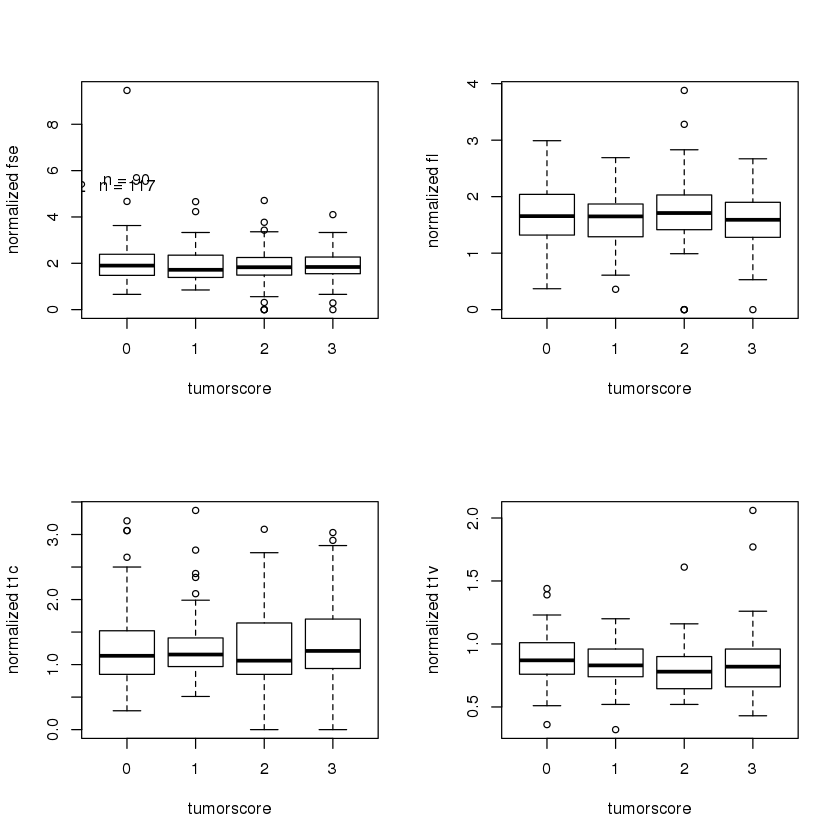

In [6]:
par(mfrow = c(2, 2))
a = boxplot(nfse ~ tumor_cell_evaluation , data = recgli, ylab = "normalized fse", xlab = "tumorscore")
text( c(1:nlevels(recgli$tumor_cell_evaluation)) , a$stats[nrow(a$stats) , ]+2 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )
boxplot(nfl ~ tumor_cell_evaluation , data = recgli, ylab = "normalized fl", xlab = "tumorscore")
boxplot(nt1c ~ tumor_cell_evaluation , data = recgli, ylab = "normalized t1c", xlab = "tumorscore")
boxplot(nt1v ~ tumor_cell_evaluation , data = recgli, ylab = "normalized t1v", xlab = "tumorscore")

### b. CEL next to NEL scores  

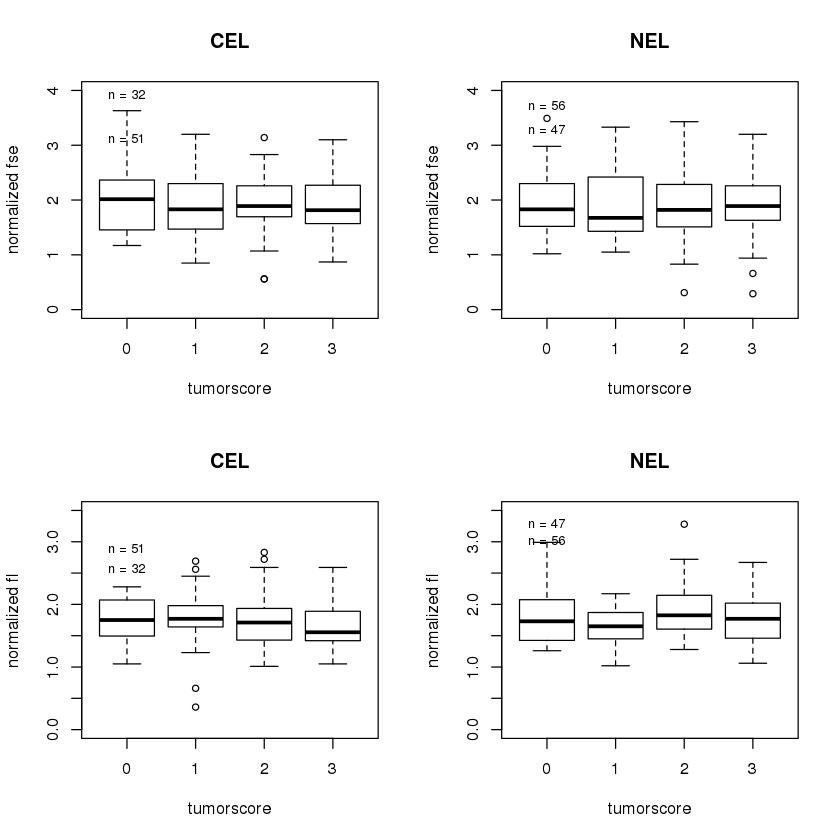

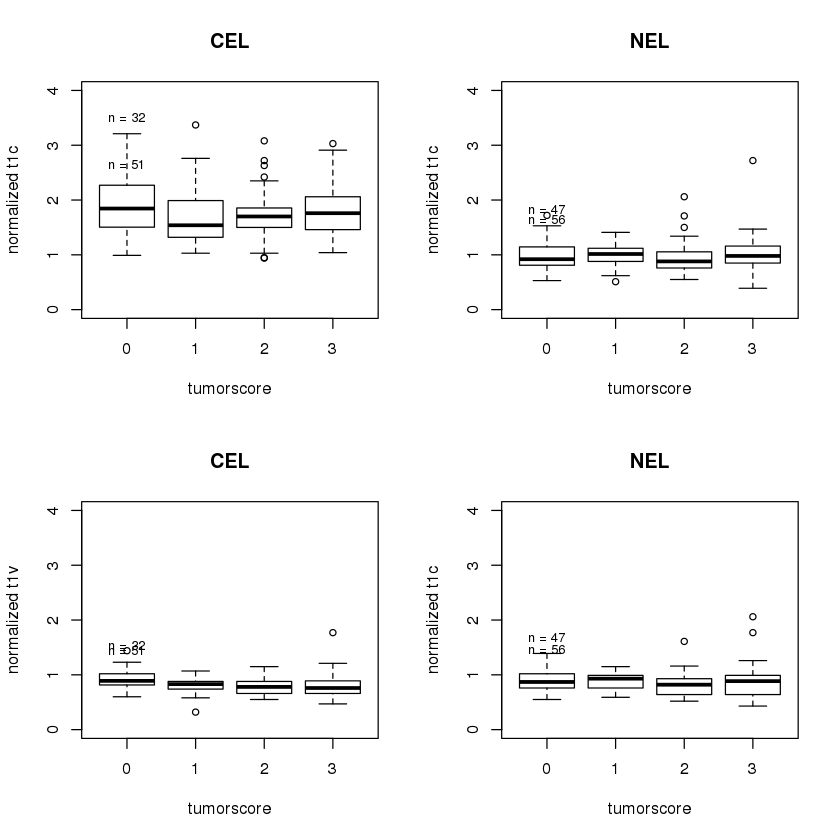

In [7]:
par(mfrow = c(2, 2))
a = boxplot(nfse ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized fse", xlab = "tumorscore", main = "CEL", ylim = c(0,4))
text( c(1:nlevels(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation)) , a$stats[nrow(a$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
b = boxplot(nfse ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized fse", xlab = "tumorscore", main = "NEL", ylim = c(0,4))
text( c(1:nlevels(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation)) , b$stats[nrow(b$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

c = boxplot(nfl ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized fl", xlab = "tumorscore", main = "CEL", ylim = c(0,3.5))
text( c(1:nlevels(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation)) , c$stats[nrow(c$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
d = boxplot(nfl ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized fl", xlab = "tumorscore", main = "NEL", ylim = c(0,3.5))
text( c(1:nlevels(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation)) , d$stats[nrow(d$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(nt1c ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized t1c", xlab = "tumorscore", main = "CEL", ylim = c(0,4))
text( c(1:nlevels(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation)) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(nt1c ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized t1c", xlab = "tumorscore", main = "NEL", ylim = c(0,4))
text( c(1:nlevels(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation)) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

g = boxplot(nt1v ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized t1v", xlab = "tumorscore", main = "CEL", ylim = c(0,4))
text( c(1:nlevels(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation)) , g$stats[nrow(g$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
h = boxplot(nt1v ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized t1c", xlab = "tumorscore", main = "NEL", ylim = c(0,4))
text( c(1:nlevels(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation)) , h$stats[nrow(h$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)


### c. Use GLMM associate anatomical parameters with TS, no separation 

There is no package with a straightforward implementation of a multinomial logistic regression with mixed effects in R. Packages w/ mixed effects modeling for logistic regression include lme4, glmm; Packages w/ multinomial log reg include mlogit. 

In [8]:
## I will come back to this later. 

### d. Use GEE to associate anatomical parameters with TS, no separation

In [9]:
library(glmnet)
library(geepack)
library(lme4)
#install.packages("multgee")
library("multgee")

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: gnm
Loading required package: VGAM
Loading required package: stats4
Loading required package: splines


In [26]:
#nfse.fit = geeglm(tumor_cell_evaluation ~ nfse, data = recgli, id = t_number, corstr = "exchangeable")
#anova(nfse.fit)

nfse.fit = ordLORgee(formula = tumor_cell_evaluation ~ nfse, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nfse.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.20100,0.28409,-4.22755,0.00002
beta20,-0.54916,0.27312,-2.01068,0.04436
beta30,0.73916,0.26321,2.80830,0.00498
nfse,0.00249,0.13007,0.01913,0.98474


In [27]:
nfl.fit = ordLORgee(formula = tumor_cell_evaluation ~ nfl, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nfl.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.07602,0.28743,-3.74359,0.00018
beta20,-0.43267,0.28023,-1.54398,0.12259
beta30,0.86553,0.27351,3.16449,0.00155
nfl,-0.07777,0.14118,-0.55088,0.58172


In [28]:
nt1c.fit = ordLORgee(formula = tumor_cell_evaluation ~ nt1c, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nt1c.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.33106,0.24358,-5.46465,0.00000
beta20,-0.69825,0.23436,-2.97940,0.00289
beta30,0.57859,0.23207,2.49316,0.01266
nt1c,0.12447,0.14702,0.84665,0.39719


In [37]:
nt1v.fit = ordLORgee(formula = tumor_cell_evaluation ~ nt1v, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nt1v.fit)$coefficients

[1] 383  73

### e. Use GLMM to associate anatomical parameters with TS, separating into CEL & NEL 

In [14]:
## need to come back to when becomes more obvious how to do GLMM with multinomial outcome... 
##can do this using a one-v-all method 

### f. Use GEE to associate anatomical parameters with TS, separating into CEL & NEL 

In [33]:
recgli_inCEL = recgli[which(recgli$in_CEL == 1),]
dim(recgli_inCEL)
is.numeric(recgli_inCEL$tumor_cell_evaluation)
head(recgli_inCEL)

[1] 158  73

[1] TRUE

,b_number,t_number,sf_number,current_scan_date,current_surgery_date,current_hist_grade,current_hist_type,roi.label,tumor_cell_evaluation,necrosis,⋯,in_CEL,in_T2all,in_NEL,in_NEC,in_ROI,desired_hist,multnom_out,no_ffpe,waiting_on_path,rhgg_txe_analysis
1,2723,6369,8122,9/13/09,9/14/09,Grade IV,Glioblastoma,10B28,0,0,⋯,1,1,0,0,1,1,TxE,0,0,1
2,2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,11B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
4,2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,12B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
6,2873,6709,8269,3/11/10,3/15/10,Grade IV,Glioblastoma,13B32,1,0,⋯,1,0,0,0,1,1,Ts1DNI,0,0,0
11,2222,6094,7758,8/3/08,8/4/08,Grade IV,Glioblastoma,15B18,0,0,⋯,1,1,0,0,1,1,TxE,0,0,1
13,2793,7584,8842,7/28/11,7/28/11,Grade IV,Glioblastoma,15B44,2,1,⋯,1,0,0,0,1,1,rHGG,0,0,1


In [42]:
coef_init = summary(nfse.fit)$coefficients[,1]

 Named num [1:4] -1.201 -0.54916 0.73916 0.00249
 - attr(*, "names")= chr [1:4] "beta10" "beta20" "beta30" "nfse"


In [43]:
nfse.fit2 = ordLORgee(formula = tumor_cell_evaluation ~ nfse, link = "logit", 
                      id = t_number, data = recgli_inCEL, LORstr = "category.exch", 
                    bstart = coef_init)
## for some reason this throws an error, I reported to the github and hope that there is a resolution of this issue 

ERROR: Error in fitLORgee(Y, X_mat, coeffs, ncategories, id, repeated, offset, : Please insert initial values


In [22]:
head(recgli)

b_number,t_number,sf_number,current_scan_date,current_surgery_date,current_hist_grade,current_hist_type,roi.label,tumor_cell_evaluation,necrosis,⋯,in_CEL,in_T2all,in_NEL,in_NEC,in_ROI,desired_hist,multnom_out,no_ffpe,waiting_on_path,rhgg_txe_analysis
2723,6369,8122,9/13/09,9/14/09,Grade IV,Glioblastoma,10B28,0,0,⋯,1,1,0,0,1,1,TxE,0,0,1
2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,11B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
3169,7540,8796,6/19/11,6/20/11,Grade IV,Glioblastoma,11B43,2,0,⋯,0,1,1,0,1,1,rHGG,0,0,1
2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,12B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
2379,5950,7930,1/25/09,1/26/09,Treatment Effect,Treatment Effect,12B22,0,0,⋯,0,1,1,0,1,1,TxE,0,0,1
2873,6709,8269,3/11/10,3/15/10,Grade IV,Glioblastoma,13B32,1,0,⋯,1,0,0,0,1,1,Ts1DNI,0,0,0
